# Wholesale Customers Dataset Segmentation Model for Consumer Analysis and Marketing Recommendation

Dataset: <https://www.kaggle.com/datasets/binovi/wholesale-customers-data-set>

This solution segments wholesale customers with **K-Means**, selects **K** using the **Elbow Method** (with silhouette as a sanity check), evaluates **PCA** pre-processing effects, and produces **cluster profiles** with **marketing recommendations** on the kaggle wholesale customers dataset.


### Hunter Worssam, September 14th, 2025


# README (Execution & Setup)

- **Python version:** `3.10.18`
- **Platform:** `Apple M4 Pro chip, running macOS-15.6.1-arm64-arm-64bit`
- **Required packages:** `numpy`, `pandas`, `scikit-learn`, `matplotlib`
- **Install instructions:**
  ```bash
  # In bash
  # python -m pip install -U numpy pandas matplotlib scikit-learn jupyter
  # Or simply pip install numpy pandas matplotlib "scikit-learn in this notebook
  ```
   ```bash
      
    ```
- **Datasets used:**
  - Download the wholesale customers dataset from kaggle via the link below:
      - https://www.kaggle.com/datasets/binovi/wholesale-customers-data-set?resource=download
  - Save this file in a folder named "data" in your working directory, and replace all spaces in the csv file name with underscores "_".
    ```bash
      
    ```

- **How to run this notebook:**
  
  1. Run all cells in order (Kernel → Restart & Run All).
  2. Verify that all code blocks run with no errors flagged.
  3. Ensure figures and tables render correctly.

In [5]:
# Environment Check & Imports
import sys, platform
from pathlib import Path
import os, sys
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score
from sklearn.decomposition import PCA

print("Python:", sys.version.split()[0])
print("Platform:", platform.platform())

try:
    import numpy as np, pandas as pd
    print("NumPy:", np.__version__)
    print("Pandas:", pd.__version__)
except Exception as e:
    print("Optional packages missing or version check failed:", e)

Python: 3.10.18
Platform: macOS-15.6.1-arm64-arm-64bit
NumPy: 1.26.4
Pandas: 2.3.2


In [6]:
## Adjustable Inputs 
USE_KAGGLE_DOWNLOAD = False
SCALE_FEATURES = True
DATA_PATH = Path("data/Wholesale_customers_data.csv")  
RANDOM_SEED = 42

# K-MEANS
k_range = range(2, 11) # Test between 2 and 10 k's
n_init = 'auto' # Default to auto here to use restarts to avoid local minima
max_iter = 500

## Wholesale Customers Dataset

1. **K-Means Segmentation**: Cluster wholesale customers and study how **K** affects segmentation. EMploy the **Elbow Method** to choose a good **K**.  
2. **PCA + Clustering**: Apply **PCA** for dimensionality reduction **before** clustering. Does the reduced data preserve core structure?  
3. **Goal**: Propose **marketing approaches** tailored to each cluster.


In [9]:
# Load CSV and normalize column names
# User must add underscores between "Wholesale" and "customers", and between "customers" and "data" following download
DATA_PATH = Path("data/Wholesale_customers_data.csv")
df = pd.read_csv(DATA_PATH)
print("Loaded:", DATA_PATH)

# Cleanup column names and visualize head of dataframe
df.columns = [c.strip().replace(' ', '_').replace('-', '_') for c in df.columns]
print('df shape:', df.shape)
display(df.head())

# Typical features: Fresh, Milk, Grocery, Frozen, Detergents_Paper, Delicatessen, plus Channel, Region
expected_cols = ['Fresh','Milk','Grocery','Frozen','Detergents_Paper','Delicassen']
print('Has expected spend columns?', all(col in df.columns for col in expected_cols))

Loaded: data/Wholesale_customers_data.csv
df shape: (440, 8)


,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


Has expected spend columns? True


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


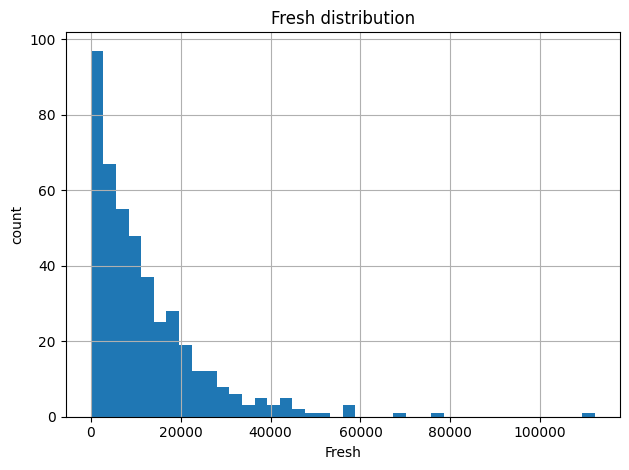

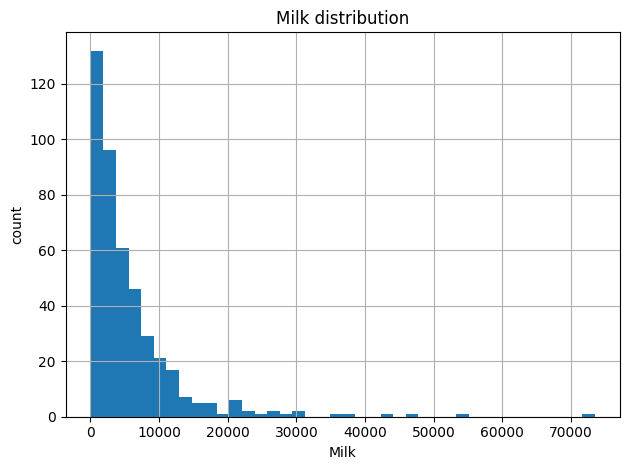

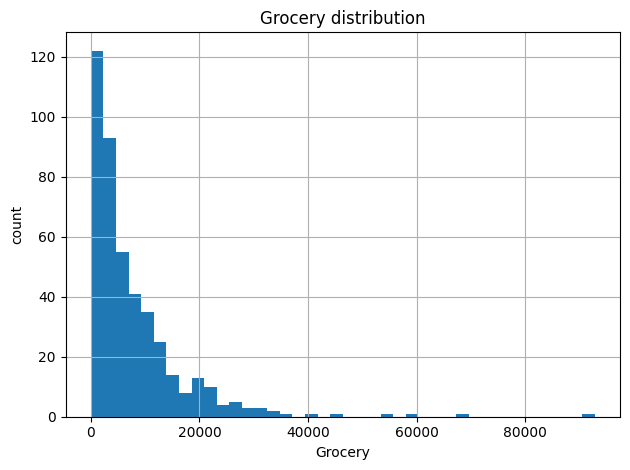

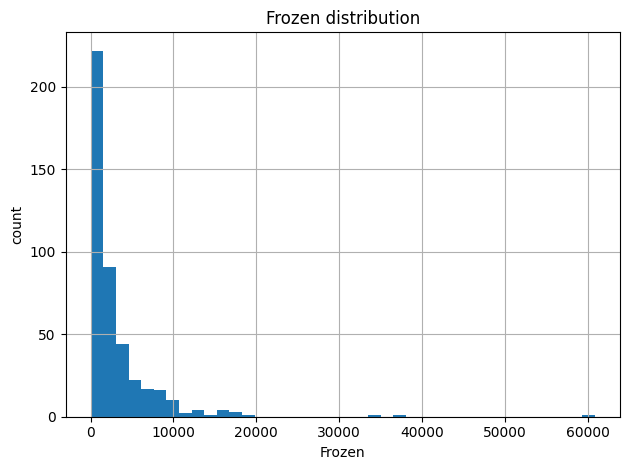

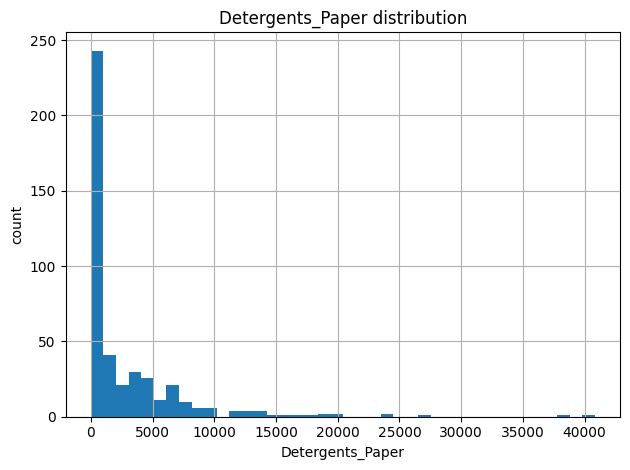

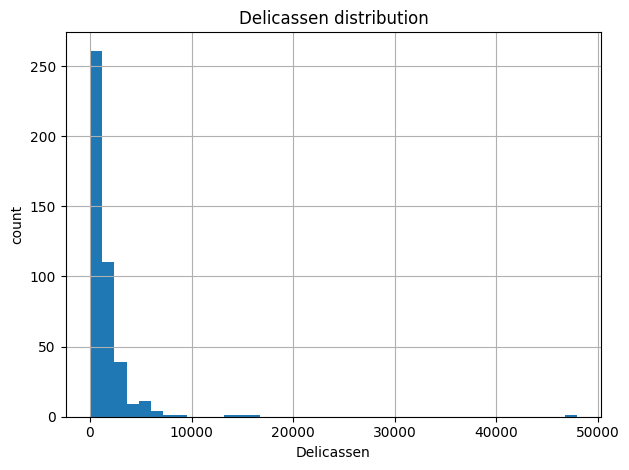

Skewness (spend columns):
Fresh                2.561323
Milk                 4.053755
Grocery              3.587429
Frozen               5.907986
Detergents_Paper     3.631851
Delicassen          11.151586
dtype: float64


In [10]:
# Simple EDA: totals and distributions (matplotlib)
spend_cols = ['Fresh','Milk','Grocery','Frozen','Detergents_Paper','Delicassen']
display(df[spend_cols].describe())
for col in spend_cols:
    plt.figure()
    df[col].hist(bins=40)
    plt.title(f'{col} distribution')
    plt.xlabel(col); plt.ylabel('count')
    plt.tight_layout(); plt.show()
print('Skewness (spend columns):')
print(df[spend_cols].skew(numeric_only=True))

In [11]:
# Standardize features for clustering using the Standard Scaler (mean = 0, std dev = 1)
spend_cols = ['Fresh','Milk','Grocery','Frozen','Detergents_Paper','Delicassen']
X = df[spend_cols].copy()
if SCALE_FEATURES:
    scaler = StandardScaler()
    X_std = scaler.fit_transform(X)
else:
    X_std = X.values
print('X_std shape:', X_std.shape)

X_std shape: (440, 6)


In [12]:
# Elbow Method (inertia) and silhouette across K
inertias, silhouettes = [], []
for k in k_range:
    km = KMeans(n_clusters=k, n_init=n_init, max_iter=max_iter, random_state=RANDOM_SEED)
    labels = km.fit_predict(X_std)
    inertias.append(float(km.inertia_))
    # silhouette requires at least 2 clusters
    sil = silhouette_score(X_std, labels) if k > 1 and len(np.unique(labels)) > 1 else np.nan
    silhouettes.append(float(sil))
print('Values of K Considered:', list(k_range))

# Choose K by max silhouette (High silouette indiciative of good balance between tight clusters and cluster separation)
best_k = int(k_range[np.nanargmax(silhouettes)])
print('Silhouette-optimal K:', best_k)

Values of K Considered: [2, 3, 4, 5, 6, 7, 8, 9, 10]
Silhouette-optimal K: 3


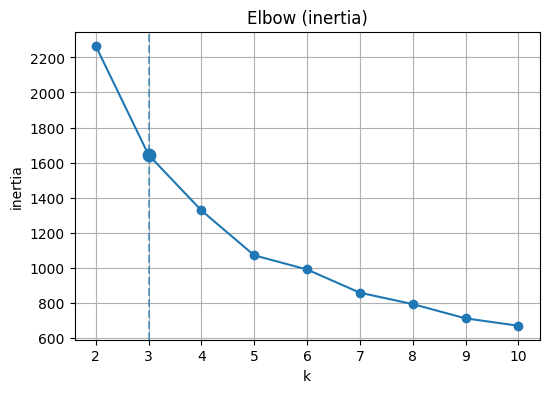

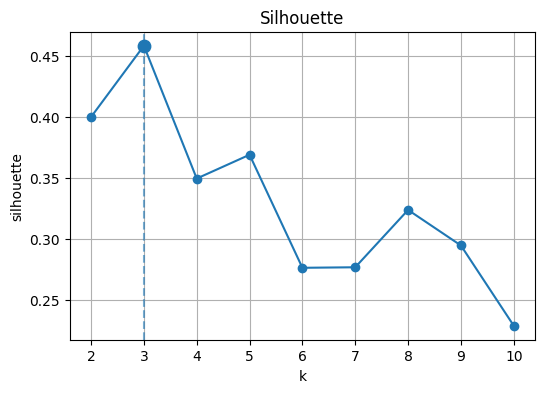

In [13]:
# Plots for Elbow (Inertia) and Silhouette
k_vals = list(k_range)

# Inertia Elbow Plot
plt.figure(figsize=(6,4))
plt.plot(k_vals, inertias, marker='o')
# Highlight best k (where "best" is based on peak silhouette value)
if 'best_k' in globals():
    elbow_y = inertias[k_vals.index(best_k)]
    plt.scatter([best_k], [elbow_y], s=80, zorder=3)
    plt.axvline(best_k, linestyle='--', alpha=0.6)
plt.title('Elbow (inertia)')
plt.xlabel('k'); plt.ylabel('inertia'); plt.grid(True)
plt.show()

# Silhouette Plot
plt.figure(figsize=(6,4))
plt.plot(k_vals, silhouettes, marker='o')
# Highlight best k (where "best" is based on peak silhouette value)
if 'best_k' in globals():
    sil_y = silhouettes[k_vals.index(best_k)]
    plt.scatter([best_k], [sil_y], s=80, zorder=3)
    plt.axvline(best_k, linestyle='--', alpha=0.6)
plt.title('Silhouette')
plt.xlabel('k'); plt.ylabel('silhouette'); plt.grid(True)
plt.show()

In [14]:
# Simple K selection (choose K)
sil_array = np.array(silhouettes, dtype=float)
max_sil = np.nanmax(sil_array)
# Below is a list comprehension to break tiebreakers incase a silhouette value is within 1e-3 of our max silhouette
# If there is a tie within our tolerance, default to the smallest k
tol = 1e-3
idxs = [i for i, s in enumerate(sil_array) if np.isclose(s, max_sil, atol=tol)]
k_star = int(k_vals[min(idxs)])  # smallest k among ties
print('Chosen K:', k_star)

Chosen K: 3


In [15]:
# Fit final KMeans and profile clusters
# Fit KMeans with chosen K
km = KMeans(n_clusters=k_star, n_init=n_init, max_iter=max_iter, random_state=RANDOM_SEED)
labels = km.fit_predict(X_std)

# Attach labels
df_clusters = df.copy()
df_clusters['cluster'] = labels

# Cluster sizes
sizes = df_clusters['cluster'].value_counts().sort_index()
display(sizes.to_frame('count').T)

# Cluster profile (means of spend features)
profile = df_clusters.groupby('cluster')[['Fresh','Milk','Grocery','Frozen','Detergents_Paper','Delicassen']].mean()
display(profile.round(0)) # Slightly cleaner formatting for our means

cluster,0,1,2
count,350,53,37


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
cluster,,,,,,
0,8936.0,4229.0,5848.0,2167.0,1914.0,1102.0
1,34540.0,5860.0,6123.0,9842.0,981.0,3664.0
2,8705.0,20534.0,30466.0,1933.0,14759.0,2459.0


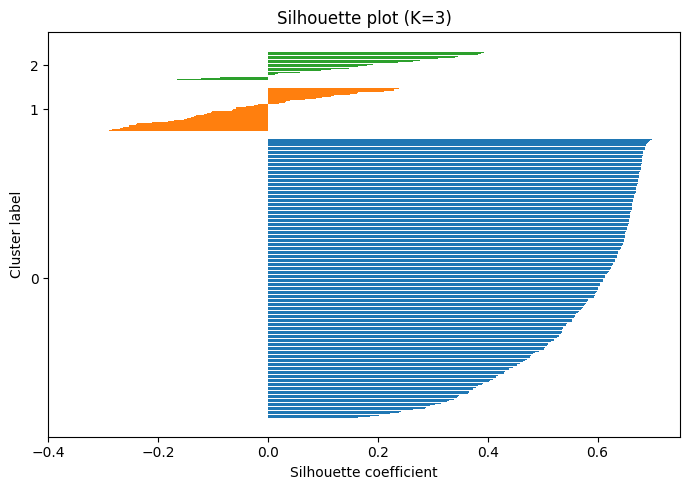

Mean silhouette by cluster: {0: 0.5649796663707998, 1: -0.04839644197493955, 2: 0.17454091762168603}
Overall mean silhouette: 0.458


In [16]:
# Silhouette plot for chosen K
# Calculate the silhouette score per sample and the average score across all three clusters
sil_vals = silhouette_samples(X_std, labels)
avg_sil = silhouette_score(X_std, labels)

# Initiate the stacked bar plot with one section per cluster
plt.figure(figsize=(7, 5))
y_lower = 10
yticks = []
clusters = sorted(np.unique(labels))

# Loops through clusters in order, taking all silhouettes for cluster c & sorting them
# Draw a horizontal bar for each sample; stacking them vertically yielding one block where height is proportional to cluster size
for c in clusters:
    c_sil = np.sort(sil_vals[labels == c])  
    size = c_sil.shape[0]
    y_upper = y_lower + size

    plt.barh(range(y_lower, y_upper), c_sil, edgecolor='none')

    # yticks created a cluster midpoint to place the y label
    yticks.append((y_lower + y_upper) / 2)
    y_lower = y_upper + 10  # gap between clusters

plt.title(f"Silhouette plot (K={k_star})")
plt.xlabel("Silhouette coefficient")
plt.ylabel("Cluster label")
plt.yticks(yticks, [str(c) for c in clusters])
plt.xlim([-0.4, 0.75])
plt.tight_layout()
plt.show()

# Potnatially useful summary info per cluster and overall
cluster_means = {int(c): float(sil_vals[labels == c].mean()) for c in clusters}
print("Mean silhouette by cluster:", cluster_means)
print(f"Overall mean silhouette: {avg_sil:.3f}")

In [17]:
# Calinski–Harabasz and Davies–Bouldin indices
ch = calinski_harabasz_score(X_std, labels)
db = davies_bouldin_score(X_std, labels)
print({'calinski_harabasz': ch, 'davies_bouldin': db})

{'calinski_harabasz': 132.3631389342484, 'davies_bouldin': 1.2490949174866433}


In [18]:
# Export cluster assignments to CSV 
OUT_PATH = Path("./wholesale_clusters.csv")
OUT_PATH.parent.mkdir(parents=True, exist_ok=True)
df_clusters.to_csv(OUT_PATH, index=False)
print("Saved to", str(OUT_PATH.resolve()))

Saved to /Users/hunterworssam/DataScience/jhu/DS Modeling & Analytics/Module 3/Homework 1/wholesale_clusters.csv


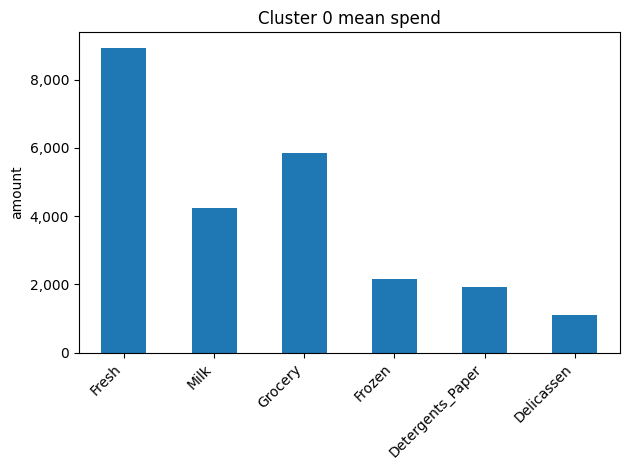

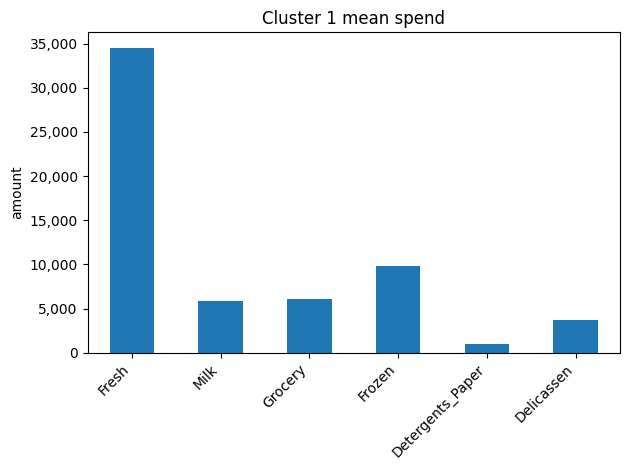

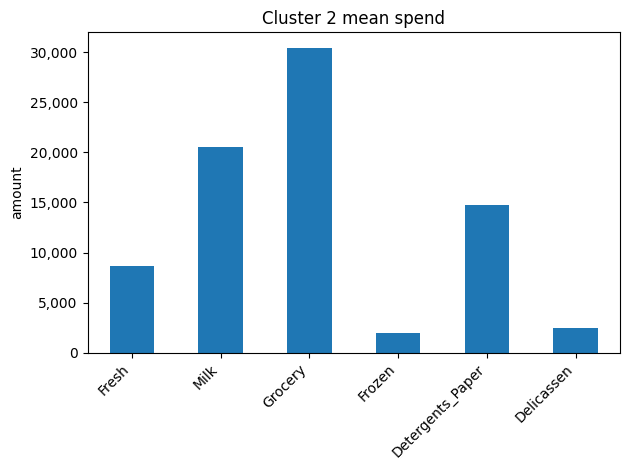

In [19]:
# Per-cluster spending profile bars

# Hardcode the spending features
features = ['Fresh','Milk','Grocery','Frozen','Detergents_Paper','Delicassen']
features = [c for c in features if c in df_clusters.columns]

fmt_thousands = FuncFormatter(lambda x, _: f'{int(x):,}')

# For each cluster, plot the mean spend for each of our categories
for c in sorted(df_clusters['cluster'].unique()):
    means = df_clusters.loc[df_clusters['cluster'] == c, features].mean()
    ax = means.plot(kind='bar')
    ax.set_title(f'Cluster {c} mean spend')
    ax.set_ylabel('amount')
    ax.yaxis.set_major_formatter(fmt_thousands)  
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

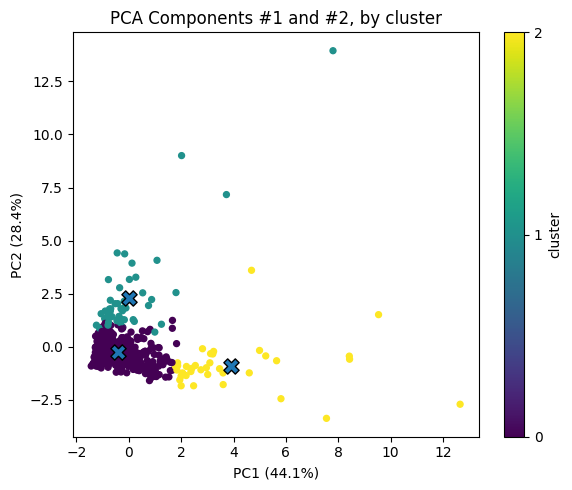

In [20]:
# PCA (2D) projection for visualization
pca = PCA(n_components=2, random_state=RANDOM_SEED)
projection = pca.fit_transform(X_std)

# Scatter plot of customers in PC space, colored by KMeans cluster label
plt.figure(figsize=(6,5))
sc = plt.scatter(projection[:, 0], projection[:, 1], c=labels, s=18)  
cb = plt.colorbar(sc, ticks=sorted(np.unique(labels)))
cb.set_label("cluster")

# Overlay KMeans centroids projected into the same PC space
try:
    centers_2d = pca.transform(km.cluster_centers_)
    plt.scatter(centers_2d[:, 0], centers_2d[:, 1],
                s=120, marker='X', edgecolor='k', linewidths=1)
except NameError:
    pass

# Include the % of explained variance in the principal component labels
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)")
plt.title("PCA Components #1 and #2, by cluster")
plt.tight_layout()
plt.show()

## Overall Kmeans model analysis & Marketing recommendations
During K-means model selection, k values between 2 and 10 were screened. Using the elbow method via the inertia plot, a clear knee around K≈3 was observed. This elbow was confirmed with the silhouette plot, where we observe a maxima at k=3, with a silhouette value of 0.46. Using the value of k=3, we arrived at cluster sizes of n0=350, n1=53, n2=37, indicating a large base segment plus two smaller, high-value segments. K>3 starts slicing the big base segment into micro-segments with diminishing separation, evident in the silhouette curve.

Mean spend analysis by cluster:

Cluster 0 (n=350): High volume of customers with moderate spend across categories
Fresh ~8.9k, Milk ~4.2k, Grocery ~5.8k, Frozen ~2.2k, Detergents/Paper ~1.9k, Delicatessen ~1.1k

Cluster 1 (n=53): Much lower customer volume with very high Fresh/Frozen/Delicatessen spend
Fresh ~34.5k, Frozen ~9.8k, Delicatessen ~3.7k; lower Det/Paper

Cluster 2 (n=37): Lowest volume of customers with very high Milk/Grocery/Detergents spend
Milk ~20.5k, Grocery ~30.5k, Det/Paper ~14.8k; lower Frozen

Clustering on PCA produced comparable segments and preserved the core data structure.

## Marketing strategy by cluster
Cluster 0: Likely a broad mix of small customers with varied interests (n=350)
To target this demographic of customer I'd focus on small weekly discounts on staple items to build loyalty and trust. As the largest portion of customers in terms of volume, it's important to build brand loyalty with this group so that they continue to come. I'd also implement rolling promotions in the underperforming areas of this group (Delicassen) to try and boost sales.


Cluster 1: Perishable-heavy ordering, likely from restaurant customers (n=53)
Assuming this group is primarily composed of resturaunt clients, I'd focus my marketing on bundles offers or bulk ordering discounts to maintain their business. These customers likely order large, somewhat fixed quantities of goods on a weekly basis, so bulk discounts could be a good opportunity to keep their business. Additionally credits towards spoilage or over ordered materials could go a long way.

Cluster 2: Retail oriented spending comprised of mostly dry-goods (n=37)
Assuming this cluster is comprised of retail customers, I'd propose loyalty programs and bulk discounts to keep their procurement teams ordering from us. We'd work closely with them to track ordering trends over time, and slowly begin to suggest additional items outside the scope of their normal ordering to try and gain sales in the underperforming areas.

## Findings & Discussion

**Elbow & Silhouette**
The elbow shows a clear knee at K=3 and the silhouette peak of 0.46 falls at K=3. Together these indicate good compactness/separation.

**Chosen K**
K = 3. Cluster sizes are 350 / 53 / 37, which includes a large base segment plus two smaller high-value groups.
See results summary section for specific cluster details.

**PCA Effects**
A 2-D PCA view captures ~72% of variance (PC1 ≈ 44.1%, PC2 ≈ 28.4%) and preserves the core structure: separation along a dry-goods axis (Milk/Grocery/Det-Paper) vs a perishables axis (Fresh/Frozen/Delicatessen). K-Means on PCA-reduced data yields comparable quality (silhouette roughly within a few hundredths), indicating dimensionality reduction does not significantly change the segmentation while aiding visualization.

**Interpretability**
PCA significantly aids in interpretibility, allowing the visualization of all three unique clusters.

**Actionability**
See marketing strategy section above for specific k-means - inspired actions.

## Results Summary

**Selected K**: clear elbow at k=3 (inertia drops sharply between 2 & 3, then flattens) and silhouette peak of 0.46 at k=3. This balances compactness and separation without over-segmenting.
  
**Segment Profiles**:
- Cluster 0 – Mixed small-volume buyers (n=350) with broad but moderatesspend across categories.

- Cluster 1 – Perishables-heavy, likey restaurant buyers (n=53): Very high Fresh (34.5k) and Frozen (9.8k) with elevated Delicassen spend.

- Cluster 2 – Retail-like spending (n=37): Very high Grocery (30.5k), Milk (20.5k), Det/Paper (14.8k), with low Frozen spend. 

**PCA Impact**: 2D PCA captures 72% of variance (PC1 44.1%, PC2 28.4%) and preserves the core perishables vs. dry-goods structure. Visual separability is clear, and clustering on PCA-reduced features is comparable to K-means.

**Recommendations**:

- Cluster 0 (Mixed low-volume buyers):
• Small weekly discounts & low MOQs to keep them coming back.
• Personalized upsell on under-indexed categories (e.g., Det/Paper or Grocery) via recommendations.

- Cluster 1 (Perishables-heavy):
• Prioritize their orders given that they are perishable and implement standing weekly orders/subscriptions.
• Spoilage credit program and volume-based discounts could maintain their interest.

- Cluster 2 (Retail):
• Tiered volume discounts on Grocery/Milk/Det-Paper and working closely with their vendor-managed inventory can help maintain this customer base.
• Loyalty programs and discounts on low-volume items to help incentivize new inventory.

## Conclusions

K-Means (with K=3) provides a clear, practical segmentation of wholesale customers. The elbow and silhouette criteria balance fit and separation, avoiding over-fragmentation. PCA reduces redundancy while preserving the core perishables vs. dry-goods structure, aiding visualization and stability. The resulting visualization maps directly to our recommended actions: discount programs for restaurants, contract pricing for retail, and simple discounts with targeted upsell for small/base buyers.

## References

- K-means and scikitlearn documentation via https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
- Kaggle: Wholesale Customers Data Set — <https://www.kaggle.com/datasets/binovi/wholesale-customers-data-set>  
- MacQueen, J. (1967). K-Means.  
- Rousseeuw, P. J. (1987). Silhouettes.  
- Jolliffe, I. T. (2002). Principal Component Analysis.
